In [93]:
# !pip install qutip

In [94]:
# Sanity check

# import qutip
# import qutip.testing
# qutip.testing.run()

The process typically takes between 10 and 30 minutes, depending on your system. It is normal for some tests to be skipped or marked as "xfail" (expected fail), especially if optional dependencies are missing or if certain features are not available on your platform. Only failures marked in red ("fail" or "error") indicate real problems

## Single Qubit Drive Testing

Relative drive strength A/wq: 0.25


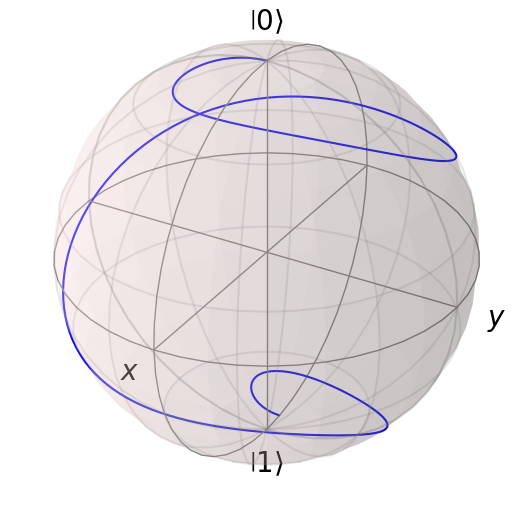

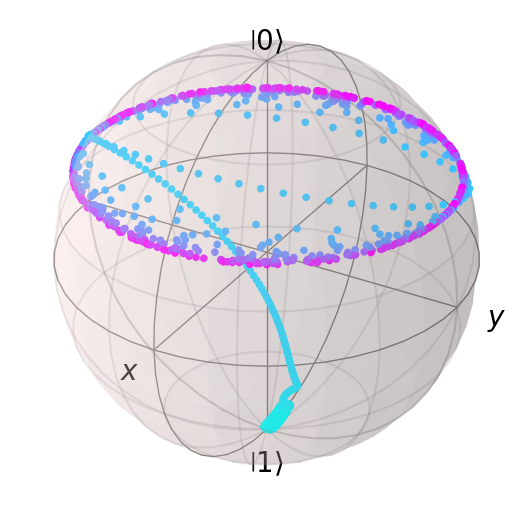

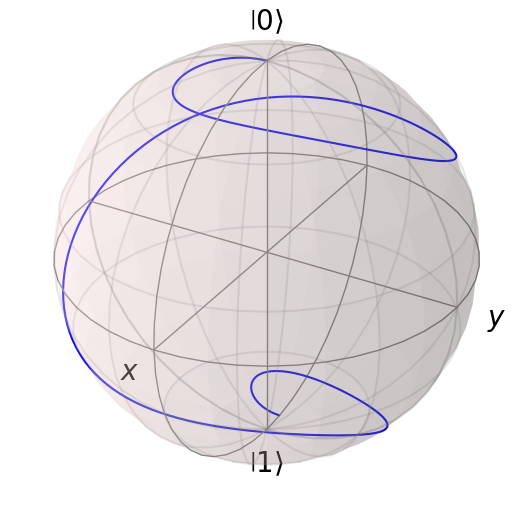

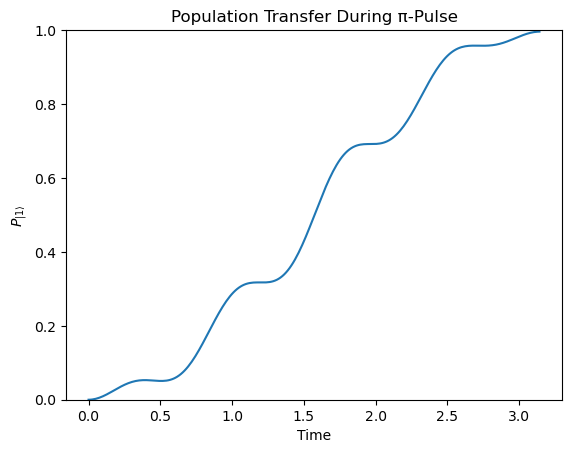

In [95]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parameters
w_q = 4    # Qubit frequency
A = 1      # Drive amplitude

print("Relative drive strength A/wq:", A/w_q)

# Even if you keep wq and wd the same, the relative drive strength A/wq leads to slower Rabi oscillations

w_d = w_q    # Resonant drive

# -----------------------------------------------------------------------------
# In a driven qubit (two-level system), a "π-pulse" is a resonant pulse that
# rotates the qubit state by π radians (180°) on the Bloch sphere, flipping it
# from |0⟩ to |1⟩ or vice versa—a quantum NOT (X) gate.
#
# On resonance (ω_d = ω_q), the Rabi frequency is Ω = A, so the time to achieve
# a π rotation is t_pi = π / A. Applying the drive for this duration ensures a
# perfect state flip. Shorter or longer pulses result in only partial rotation.
# -----------------------------------------------------------------------------

t_pi = np.pi/A  # π-pulse duration
tlist = np.linspace(0, t_pi, 250)

# Initial state: |0⟩
psi0 = qt.basis(2, 0)

# Hamiltonian
def drive_coeff(t, args):
    return A * np.cos(args['w_d'] * t)

H = [w_q/2 * qt.sigmaz(), [qt.sigmax(), drive_coeff]]
args = {'w_d': w_d}

# Solve
result = qt.mesolve(H, psi0, tlist, [], [], args=args)

# Bloch sphere visualization
sx = [qt.expect(qt.sigmax(), state) for state in result.states]
sy = [qt.expect(qt.sigmay(), state) for state in result.states]
sz = [qt.expect(qt.sigmaz(), state) for state in result.states]

b = qt.Bloch()
b.add_points([sx, sy, sz], meth='l')
b.show()

# Corrected population calculation
pop1 = [np.abs(state.overlap(qt.basis(2,1)))**2 for state in result.states]  # FIXED

plt.figure()
plt.plot(tlist, pop1)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel(r'$P_{|1\rangle}$')
plt.title('Population Transfer During π-Pulse')
plt.show()


### Relative Drive Slider Testing

In [96]:
from ipywidgets import interact, FloatSlider

def qubit_drive_sim(rel_drive_strength=1.0):
    """
    Simulate and plot qubit NOT gate dynamics for adjustable relative drive strength (A/w_q).
    Shows initial and final state vectors on the Bloch sphere and prints the final state.
    """
    w_q = 4.0  # Fixed qubit frequency
    A = rel_drive_strength * w_q
    w_d = w_q
    t_pi = np.pi / A
    tlist = np.linspace(0, t_pi, 250)
    psi0 = qt.basis(2, 0)
    
    def drive_coeff(t, args):
        return A * np.cos(args['w_d'] * t)

    H = [w_q/2 * qt.sigmaz(), [qt.sigmax(), drive_coeff]]
    args = {'w_d': w_d}
    result = qt.mesolve(H, psi0, tlist, [], [], args=args)

    sx = [qt.expect(qt.sigmax(), state) for state in result.states]
    sy = [qt.expect(qt.sigmay(), state) for state in result.states]
    sz = [qt.expect(qt.sigmaz(), state) for state in result.states]

    b = qt.Bloch()
    b.add_points([sx, sy, sz], meth='l')
    # Add vector for initial state (north pole)
    b.add_vectors([0, 0, 1])
    # Add vector for final state
    final_state = result.states[-1]
    sx_f = qt.expect(qt.sigmax(), final_state)
    sy_f = qt.expect(qt.sigmay(), final_state)
    sz_f = qt.expect(qt.sigmaz(), final_state)
    b.add_vectors([sx_f, sy_f, sz_f])
    b.show()

    # Print the final state as an array
    print("Final state vector (ket):")
    print(final_state.full())

    pop1 = [np.abs(state.overlap(qt.basis(2,1)))**2 for state in result.states]

    plt.figure()
    plt.plot(tlist, pop1)
    plt.ylim(0, 1)
    plt.xlabel('Time')
    plt.ylabel(r'$P_{|1\rangle}$')
    plt.title(f'Population Transfer (A/w_q = {rel_drive_strength:.2f})')
    plt.show()

# Only the relative drive strength is controlled by the slider
interact(qubit_drive_sim, rel_drive_strength=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.05, description='A/w_q'))

# Note:
# The code's imperfection comes from simulating the full physical Hamiltonian, not from modeling noise or hardware errors.

interactive(children=(FloatSlider(value=1.0, description='A/w_q', max=2.0, min=0.1, step=0.05), Output()), _do…

<function __main__.qubit_drive_sim(rel_drive_strength=1.0)>

### RWA Hamiltonian (perfect NOT operation)

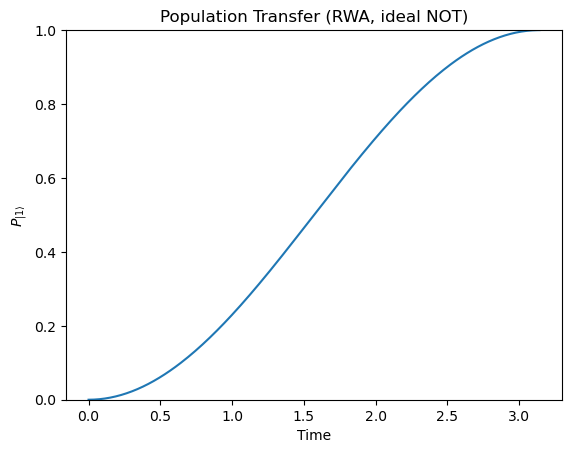

In [97]:
# RWA Hamiltonian for a perfect NOT
A = 1
t_pi = np.pi/A
tlist = np.linspace(0, t_pi, 250)
psi0 = qt.basis(2, 0)
H_rwa = (A/2) * qt.sigmax() # RWA Hamiltonian for a perfect NOT

result = qt.mesolve(H_rwa, psi0, tlist, [], [])
pop1 = [np.abs(state.overlap(qt.basis(2,1)))**2 for state in result.states]

plt.plot(tlist, pop1)
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel(r'$P_{|1\rangle}$')
plt.title('Population Transfer (RWA, ideal NOT)')
plt.show()


## Printing Sigma x y and z versus time with varying initial conditions

In [117]:
from qutip import sigmax, sigmay, sigmaz
from sympy import Matrix, latex

print("Sigma_x:\n", sigmax().full())
print("Sigma_y:\n", sigmay().full())
print("Sigma_z:\n", sigmaz().full())

Sigma_x:
 [[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Sigma_y:
 [[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]
Sigma_z:
 [[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


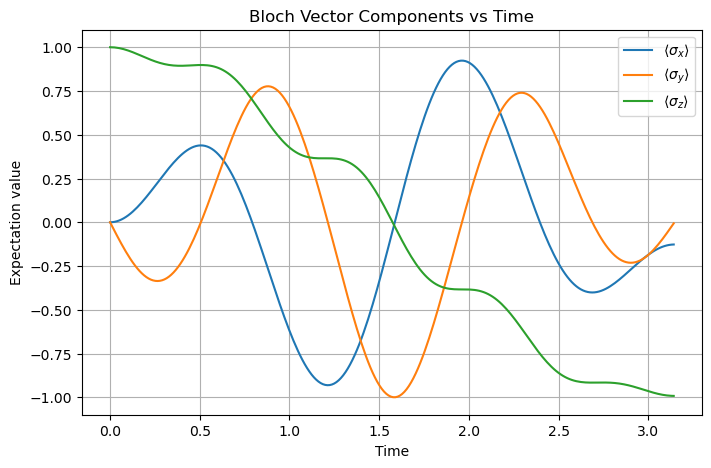

In [99]:
plt.figure(figsize=(8, 5))
plt.plot(tlist, sx, label=r'$\langle \sigma_x \rangle$')
plt.plot(tlist, sy, label=r'$\langle \sigma_y \rangle$')
plt.plot(tlist, sz, label=r'$\langle \sigma_z \rangle$')
plt.xlabel('Time')
plt.ylabel('Expectation value')
plt.title('Bloch Vector Components vs Time')
plt.legend()
plt.grid(True)
plt.show()

## Optimal Control

### GRAPE

## Multiple Qubits

# Example Notebooks

## Bloch Sphere with colorbar

In [100]:
import matplotlib as mpl
import numpy as np
from matplotlib import cm
from qutip import Bloch, about, basis, destroy, sesolve, sigmax, sigmay, sigmaz

%matplotlib inline

In [101]:
delta = 0.5 * 2 * np.pi
v = 2.0 * 2 * np.pi  # sweep rate

H0 = delta / 2.0 * sigmax()
H1 = v / 2.0 * sigmaz()
H = [H0, [H1, "t"]]
psi0 = basis(2, 0)

sm = destroy(2)
sx = sigmax()
sy = sigmay()
sz = sigmaz()
expt_ops = [sm.dag() * sm, sx, sy, sz]


tlist = np.linspace(-10.0, 10.0, 1500)
expt_list = sesolve(H, psi0, tlist, expt_ops).expect
expt_list = [np.array(exp) for exp in expt_list]

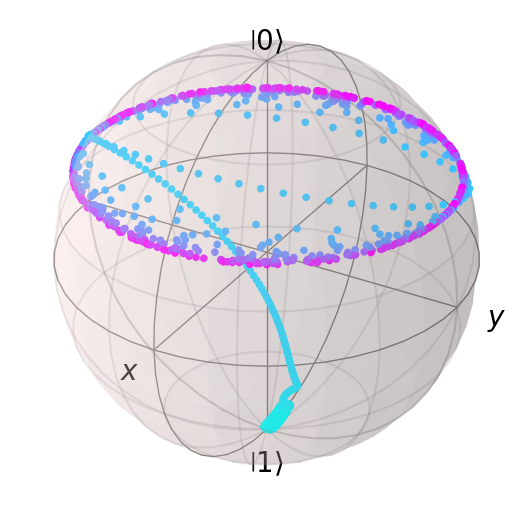

In [102]:
b = Bloch()
# normalize colors to times in tlist ##
nrm = mpl.colors.Normalize(-2, 10)
colors = cm.cool(nrm(tlist))

# add data points from expectation values ##
b.add_points([expt_list[1], expt_list[2], -expt_list[3]], "m")

# customize sphere properties ##
b.point_color = list(colors)
b.point_marker = ["o"]
b.point_size = [20]

b.zlpos = [1.1, -1.2]

b.show()

## Energy-level diagrams

In [108]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
from qutip import about, qeye, sigmax, sigmaz, tensor

%matplotlib inline

In [109]:
def compute(w1list, w2, w3, g12, g13):

    # Pre-compute operators for the hamiltonian
    sz1 = tensor(sigmaz(), qeye(2), qeye(2))
    sx1 = tensor(sigmax(), qeye(2), qeye(2))

    sz2 = tensor(qeye(2), sigmaz(), qeye(2))
    sx2 = tensor(qeye(2), sigmax(), qeye(2))

    sz3 = tensor(qeye(2), qeye(2), sigmaz())
    sx3 = tensor(qeye(2), qeye(2), sigmax())

    idx = 0
    evals_mat = np.zeros((len(w1list), 2 * 2 * 2))
    for w1 in w1list:

        # evaluate the Hamiltonian
        H = w1 * sz1 + w2 * sz2 + w3 * sz3 + g12 * sx1 * sx2 + g13 * sx1 * sx3

        # find the energy eigenvalues of the composite system
        evals, ekets = H.eigenstates()

        evals_mat[idx, :] = np.real(evals)

        idx += 1

    return evals_mat

In [110]:
w1 = 1.0 * 2 * pi  # atom 1 frequency: sweep this one
w2 = 0.9 * 2 * pi  # atom 2 frequency
w3 = 1.1 * 2 * pi  # atom 3 frequency
g12 = 0.05 * 2 * pi  # atom1-atom2 coupling strength
g13 = 0.05 * 2 * pi  # atom1-atom3 coupling strength

w1list = np.linspace(0.75, 1.25, 50) * 2 * pi  # atom 1 frequency range
evals_mat = compute(w1list, w2, w3, g12, g13)

In [111]:
fig, ax = plt.subplots(figsize=(12, 6))

for n in [1, 2, 3]:
    ax.plot(w1list / (2 * pi),
            (evals_mat[:, n] - evals_mat[:, 0]) / (2 * pi), "b")

ax.set_xlabel("Energy splitting of atom 1")
ax.set_ylabel("Eigenenergies")
ax.set_title("Energy spectrum of three coupled qubits")

Text(0.5, 1.0, 'Energy spectrum of three coupled qubits')

In [107]:
about()



QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0
Numpy Version:      1.26.4
Scipy Version:      1.13.1
Cython Version:     None
Matplotlib Version: 3.9.2
Python Version:     3.12.7
Number of CPUs:     16
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Windows (AMD64)
Installation path:  c:\Users\Owner\anaconda3\Lib\site-packages\qutip

Installed QuTiP family packages
-------------------------------

No QuTiP family packages installed.

Please cite QuTiP i

In [113]:
qt.cite()

@misc{qutip5,
  title = {{QuTiP} 5: The Quantum Toolbox in {Python}},
  author = {Lambert, Neill and Giguère, Eric and Menczel, Paul and Li, Boxi
    and Hopf, Patrick and Suárez, Gerardo and Gali, Marc and Lishman, Jake
    and Gadhvi, Rushiraj and Agarwal, Rochisha and Galicia, Asier
    and Shammah, Nathan and Nation, Paul D. and Johansson, J. R.
    and Ahmed, Shahnawaz and Cross, Simon and Pitchford, Alexander
    and Nori, Franco},
  year={2024},
  eprint={2412.04705},
  archivePrefix={arXiv},
  primaryClass={quant-ph},
  url={https://arxiv.org/abs/2412.04705},
  doi={10.48550/arXiv.2412.04705},
}
